# `Process Data`

Import Python libraries

In [2]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import astroML 
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=14, usetex=True)
import astropy

from scipy import stats
import scipy.optimize as op
import scipy.signal as sig
import scipy.constants as const
from scipy.signal import argrelextrema, medfilt

from random import uniform, randrange
import kplr
from kplr.ld import get_quad_coeffs
import time
from collections import Counter, defaultdict, OrderedDict
import glob, os
from multiprocessing import Pool, cpu_count
import itertools
import transit
import emcee
import corner

Confirm that the version of `emcee` is the latest (as of Aug 2018, it's 3.0rcl')

In [3]:
emcee.__version__

'3.0rc1'

Check the number of CPU's available in this computer.

In [4]:
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

8 CPUs


Standarize plots 

In [5]:
rcParams['figure.figsize'] = 16, 7
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

Load $\text{LaTeX}$

In [6]:
pgf_with_latex = {
    "pgf.texsystem": "xelatex",         # use Xelatex which is TTF font aware
    "text.usetex": True,                # use LaTeX to write all text
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "text.latex.unicode": True,
    "pgf.preamble": [
        r'\usepackage{fontspec}',
        r'\setmainfont{Ubuntu}',
        r'\setmonofont{Ubuntu Mono}',
        r'\usepackage{unicode-math}'
        r'\setmathfont{Ubuntu}'
        r'\usepackage{amsmath}' #for \text command
    ]
}

rcParams.update(pgf_with_latex)

# Global Parameters

General parameters from the NASA Kepler Mission

In [7]:
bjd_ref = 2454833
sc = 58.0  #sc = 58 sec
tKep = sc/60/60/24  # sc in days
print(tKep)

0.0006712962962962962


Physical constants

In [8]:
G = 6.6730e-11

Transit detection parameters

In [9]:
poly_order = 3
amplify = 2
snr_limit = 3.0

print("Amplification of transit duration by:", amplify)
print("The SNR limit of each transit has been set to", snr_limit)

Amplification of transit duration by: 2
The SNR limit of each transit has been set to 3.0


MCMC Global Initialization Parameters

In [41]:
period_guess = 30
steps_rho, nwalkers_rho = 10000, 100
steps, nwalkers = 10000, 100

burnin_rho = int(steps_rho/10) 
burnin_global = int(steps/5)

Prepare the headers we will use in the text files containing the results of my code.

In [11]:
id_mcmc = ["Depth:", "Impact parameter (b):", "sigma:", "Stellar Mass (Ms, [Solar mass]):",
           "Stellar Radius (Rs, [Solar Radii]):", "Out-of-transit flux (f0):", "Orbital Period (P, [days]):", 
           "Time of transit (tc, [days]):", "Planetary Radius (Rp, [Rearth]):", "Rs_a:"]

header_mcmc = "This file shows the 50% percentile and the +- 1 sigma error interval of the parameters.\n"

header_rs = "This file shows the 50% percentile for the Stellar Radius (in solar radii), \
its +- 1 sigma error interval, and the MCMC acceptance fraction (in %). Note that these results \
are for the star's *observed* transits with a minimum SNR of {0:f}. \n".format(snr_limit)

Confirm `os.environ=1` for the MCMC parallelization (advice given here: https://emcee.readthedocs.io/en/latest/tutorials/parallel/)

In [12]:
os.environ["OMP_NUM_THREADS"] = "1"

# Introduction

## Load the data

In [13]:
path_file = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/clean_bat_files/LC_p13point5up/'
path_mergedLC = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/merge_light_curves/LC_p13point5up_merged/'

properties_sample = pd.read_csv(path_file+'all_targets_P13point5up.csv', sep=',', comment='#')
targets = pd.read_csv(path_file + 'kepler_id.txt',delimiter=',', dtype=int, header=None, names=['kepid'])

In [14]:
df = pd.merge(targets, properties_sample, on=['kepid'], how='inner') 
sc_data = df.drop_duplicates('kepid') #remove duplicates (some systems have both sc and lc LC)

print("Check files:")

if (len(targets) != len(properties_sample)):
    print("(*) Lengths don't match:", len(targets), len(properties_sample))
    print("\tSome systems have both sc and lc data! Remove duplicates.")

if (len(sc_data) == len(targets)):
    print("(*) Lengths match:", len(sc_data), len(targets))
    print('\tDuplicates have been removed.\n A total of {} systems have *short-cadence* LC with SN > 7.1 for their first transit and only 1 planet'.format(len(sc_data)))
    
sc_data.shape

Check files:
(*) Lengths don't match: 55 984
	Some systems have both sc and lc data! Remove duplicates.
(*) Lengths match: 55 55
	Duplicates have been removed.
 A total of 55 systems have *short-cadence* LC with SN > 7.1 for their first transit and only 1 planet


(55, 141)

0.738 1.927
0.74 1.486


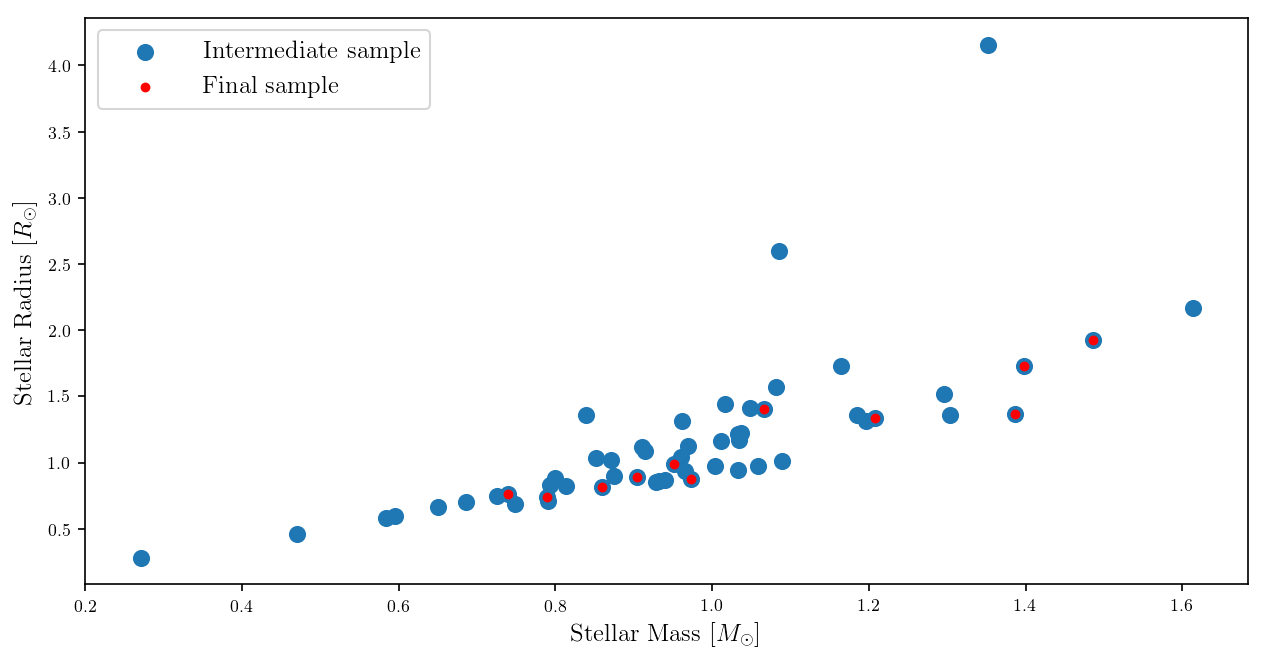

In [15]:
final_list_stars = {'rad': [0.738, 1.407, 0.993, 0.817, 1.367, 1.927, 1.337, 0.765 , 0.879, 1.731, 0.892], 
                    'mass': [0.79, 1.066, 0.951, 0.860, 1.386, 1.486, 1.208, 0.740, 0.973, 1.398, 0.904],
                   'teff': [4941, 5868, 5683, 5303, 6823, 6273, 6407, 4939, 5510, 6430, 5591]}

final_stars = pd.DataFrame(data=final_list_stars)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.scatter(sc_data['koi_smass'].values, sc_data['koi_srad'], marker = 'o', label='Intermediate sample', s = 52);
ax.scatter(final_stars['mass'], final_stars['rad'], marker = '.', color ='r', label = 'Final sample', s = 55)
ax.set_ylabel('Stellar Radius [$R_{\odot}$]',fontsize = 12)
ax.set_xlabel(r'Stellar Mass [$M_{\odot}$]', fontsize = 12)
ax.legend(fontsize = 12)
plt.savefig('kepler_sample.png', bbox_inches='tight')

print(min(final_stars['rad'].values), max(final_stars['rad'].values))
print(min(final_stars['mass'].values), max(final_stars['mass'].values))

4939 6823


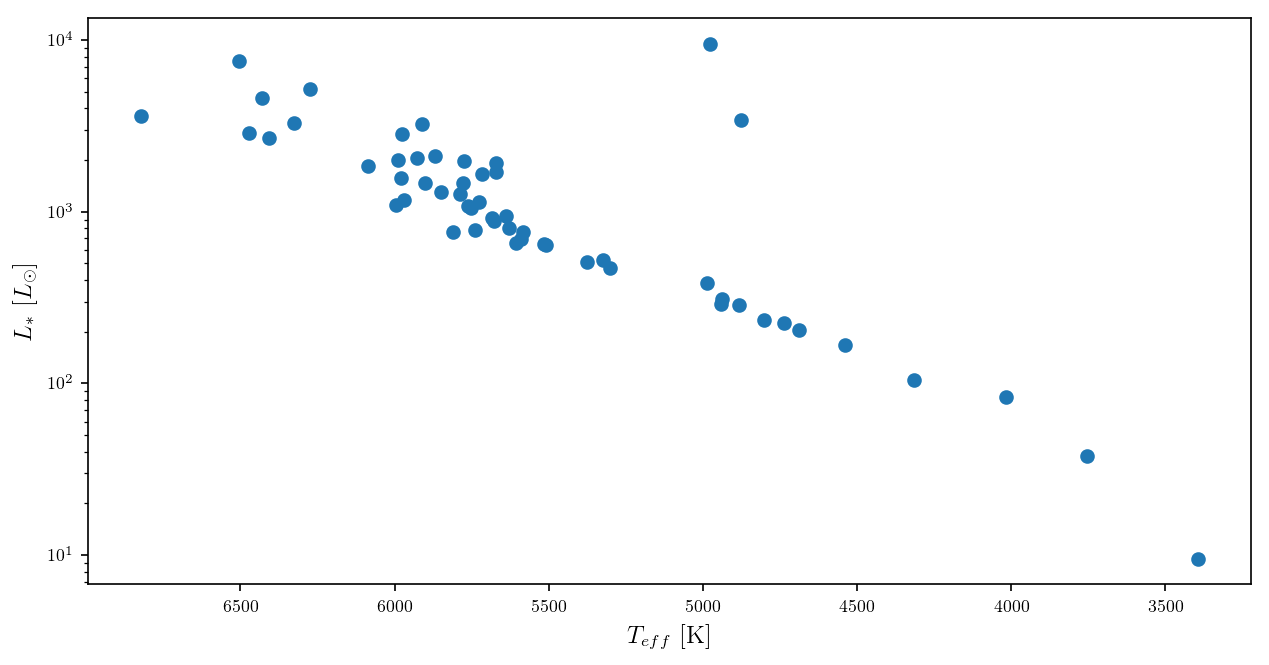

In [16]:
def get_lum(data, R, T):
    luminosity = []
    for i in range(len(data)):
        r_meters = (sc_data['koi_srad'].values[i])*(6.957*10e8)
        teff_kelvin = sc_data['koi_steff'].values[i]
        l_watt = 4*np.pi*(const.Stefan_Boltzmann)*(r_meters**2)*(teff_kelvin**4)
        l_solar = l_watt*(2.599*10e-27)
        luminosity.append(l_solar)
    return luminosity 
    

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.semilogy(sc_data['koi_steff'].values, get_lum(sc_data,sc_data['koi_srad'].values, sc_data['koi_steff'].values),'o')
#ax.semilogy(final_stars['teff'].values, get_lum(final_stars, final_stars['rad'].values, final_stars['teff'].values),'o')
ax.set_xlabel(r'$T_{eff}$ [K]', fontsize = 12)
ax.set_ylabel(r'$L_{*}$ [$L_{\odot}$]', fontsize = 12)
ax.invert_xaxis()
plt.savefig('kepler_sample_HR.png', bbox_inches='tight')

print(min(final_stars['teff'].values), max(final_stars['teff'].values))

## Define the Systems

In [17]:
class System:    
    def __init__(self, kepid, rs, rs_err, smass, smass_err, teff, logg, feh, srho,
                time_BKJD, flux, flux_err, 
                t0, P, depth, b, duration, u1, u2, diffld, num_planets, incl, eccen, dor, sma,
                 transit_times,ind_missed_transits,
                rp, rp_solarRad, rp_err, teq, mp, 
                 trans_id, ftrans, ftrans_err, ttrans, dt_trans,
                full_P_trans, full_P, best_stats, full_P_trans_stats, full_stats, 
                 min_flux_folded):
        
        """****** Kepler Reported Stellar Parameters ******"""
        self.kepid = kepid
        self.rs = rs # [Solar radii]. 
        self.rs_err = rs_err
        self.smass = smass # [Solar mass]
        self.smass_err = smass_err
        
        self.teff = teff;     
        self.logg = logg; # Stellar Surface Gravity [log10(cm/s**2)]  
        self.feh = feh;   
        self.srho = srho; #g/cm3
        
        """****** LC parameters ******"""
        self.time_BKJD = time_BKJD
        self.flux = flux
        self.flux_err = flux_err
        
        """****** Transit Parameters ******"""
        self.t0 = t0
        self.P = P;            
        self.depth = depth;  
        self.b = b; 
        self.duration = duration; 
        self.u1 = u1; 
        self.u2 = u2
        self.diffld = 0.0
        self.num_planets = num_planets
        self.incl = incl #[º]
        self.eccen = 0.0
        self.dor = dor #Planet-Star Distance over Star Radius
        self.sma = sma #Orbital semi-major axis [AU]
        
        self.transit_times = transit_times
        self.ind_missed_transits = ind_missed_transits
                   
        """****** Planetary Parameters ******"""
        self.rp = rp # [Earth radii]. This is "prad"  in the original file
        self.rp_solarRad = rp*0.009168 # in solar radii
        self.rp_err = rp_err
        self.teq = teq
        self.mp = 2.69*(rp)**(0.93) #Weiss & Marcy rel'n. It requires Rp in Earth radii
        
        """****** Internal Variables ******"""
        self.trans_id = np.empty(0)
        self.ftrans = np.empty(0)
        self.ftrans_err = np.empty(0)
        self.ttrans = np.empty(0)
        self.dt_trans = np.empty(0)
        
        
        self.full_P_trans =  np.empty(0)
        self.full_P =  np.empty(0)
        self.best_stats =  np.empty(0)
        self.full_P_trans_stats = np.empty(0)
        self.full_stats = np.empty(0)
        
        self.min_flux_folded = 0.0
        

## Characterize the Systems

Some initialization functions: `quadraticLD`calculates the quadratic LD coefficients of a star based on the model from Claret & Bloemen (2011). As for `fetchLC`, it simply loads the systems' light curves.

In [18]:
def quadraticLD(T, G, FEH): 
    """Confirm the quadratic LD coefficients with a model from Claret & Bloemen (2011).
    Use the Claret coefficients instead."""
    mu1, mu2 = get_quad_coeffs(T, G, FEH)
    return (mu1, mu2)

def fetchLC(name):
    id_kep = "%.0f" % name
    lc = path_mergedLC+('KID'+id_kep+'.txt')
    df = pd.read_csv(lc, sep="\t", skiprows=1, header=None, names=["Time BKJD", "Flux", "Flux_Err"])
    y = df['Flux']
    yerr = df['Flux_Err']
    x = df['Time BKJD']
    return (y, yerr, x)







Create the planet+star system. In this research, we will only evaluate systems with only 1 planet. 

In [19]:
targets = []

for row in sc_data.itertuples(index = True, name='Pandas'):
    kepid = getattr(row, "kepid")
    fluxLC, fluxLC_err, timeLC_BKJD = fetchLC(kepid)

    ## Store the stellar parameters
    rs = getattr(row, "koi_srad") #solar radii
    smass = getattr(row, "koi_smass")
    
    #Assuming that we have a 5% error on radius and mass (this is sensible thanks to Gaia)
    rs_err = rs*0.05
    smass_err = smass*0.05
    
    teff = getattr(row, "koi_steff")
    logg = getattr(row, "koi_slogg") # Stellar Surface Gravity [log10(cm/s**2)]  
    feh = getattr(row, "koi_smet")
    srho = getattr(row, "koi_srho") #g/cm3
    
    #### Store LC Parameters
    t0 = getattr(row, "koi_time0bk")
    P = getattr(row, "koi_period") # Orbital Period [days]
    depth = getattr(row, "koi_depth")/1e6
    b = getattr(row, "koi_impact")
    
    u1, u2 = quadraticLD(teff,logg,feh)

    num_planets = getattr(row, "koi_count")
    incl =  getattr(row, "koi_incl") #in degrees
    dor = getattr(row, "koi_dor")  #Planet-Star Distance over Star Radius
    
    duration = getattr(row, "koi_duration")/24. #in days. "Duration is measured from first contact between the planet and star until last contact."
    
    #Planetary parameters
    sma = getattr(row, "koi_sma")  #Orbit Semi-Major Axis [AU]
    sma_solarRad = sma*215
    teq = getattr(row, "koi_teq") 
    rp = getattr(row, "koi_prad") # in Earth radii
    rp_errPos = getattr(row, "koi_prad_err1"); rp_errNeg = getattr(row, "koi_prad_err2")
    rp_err = np.sqrt(rp_errPos**2+rp_errNeg**2)
        
    if (num_planets == 1):
        system = System(kepid, rs, rs_err, smass, smass_err, teff, logg, feh, srho,
                    timeLC_BKJD, fluxLC, fluxLC_err, 
                    t0, P, depth, b, duration, u1, u2, u1-u2, num_planets, incl, 0.0, dor, sma,
                        None, None,
                    rp, None, rp_err, teq, None, 
                        None, None, None, None, None,
                       None, None, None, None, None,
                       0.0)

        targets.append(system)
                
    else:
        print('Star {:s} not stored (koi_count > 1)'.format(str(kepid)))

# Transit Detection

In [20]:
def find_transits(star):
    ti = min(star.time_BKJD)
    tf = max(star.time_BKJD)
    
    n_min = int((ti-star.t0)/star.P)
    n_max = int((tf-star.t0)/star.P+1.)
    n = np.arange(n_min, n_max)
    
    t = star.t0+n*star.P
    t = t[t>ti] 
    t = t[t<tf]
    return(t)

In [21]:
def show_folded_lightcurve(star, plot=False):
    if plot==True:
        plt.figure(figsize=(15,6))
        plt.plot(star.dt_trans,star.ftrans,'.', ms = 2)     
        plt.title('Folded LC for KID'+str(star.kepid))
        plt.xlabel('Time from midtransit [d]'); plt.ylabel('Normalized Flux')
        plt.show(block=False)    
        time.sleep(0.1)
        plt.close()

def mark_transits(star, obs_trans, plot=False):
    if plot==True:
        fig = plt.figure(figsize=(13,6))
        plt.plot(star.time_BKJD,star.flux,'.')        
        for j in range(len(star.transit_times)): 
            plt.axvline(star.transit_times[j], color='k', ls='-')
        for k in range(len(obs_trans)): 
            plt.axvline(obs_trans[k], color='r', ls='--')
        plt.title('KID'+str(star.kepid))
        plt.xlabel('Time BKJD [d]'); plt.ylabel('Normalized Flux')
        plt.savefig("results/marked_transits/"+str(star.kepid)+".png", bbox_inches='tight')
        plt.show(block=False)    
        time.sleep(0.1)
        plt.close()
        
def show_transits(star, bad_trans, plot=False):        
    s1 = set(bad_trans)
    if plot==True:   
        for i in range(len(star.transit_times)):
            if (i not in bad_trans):
                fig = plt.figure(figsize=(15,6))
                plt.title('Transit '+str(i+1))
                plt.plot(star.ttrans[star.trans_id==i]-star.transit_times[i],star.ftrans[star.trans_id==i], 'k.', ms = 2)     
                plt.xlabel('Time from midtransit [d]'); plt.ylabel('Normalized Flux')
                plt.show(block=False)    
                time.sleep(0.1)
                plt.close(fig)

In [22]:
def get_data_in_transit(star, factor):
    window = factor*star.duration # In days
    total_points = 0
    
    for i in range(0,len(star.transit_times)):
        residual = star.time_BKJD - star.transit_times[i]
        points_in_transit = np.abs(residual) <= window
        total_points += np.sum(points_in_transit)
  
    time_in_transit = np.empty(total_points)
    flux_in_transit = np.empty(total_points)
    flux_err_in_transit = np.empty(total_points)
    flag_transit = np.empty(total_points)
    mid_trans = np.empty(total_points)

    total_points = 0
 
    for i in range(0, len(star.transit_times)):
        points_in_transit = np.abs(star.time_BKJD - star.transit_times[i]) <= window
        count_points = np.sum(points_in_transit)
        time_in_transit[(0 + total_points):(count_points + total_points)] = star.time_BKJD[points_in_transit]
        flux_in_transit[(0 + total_points):(count_points + total_points)] = star.flux[points_in_transit] #, star.flux_err[points_in_transit])[0]
        flux_err_in_transit[(0 + total_points):(count_points + total_points)] = star.flux_err[points_in_transit] #normalize(star.flux[points_in_transit], 
        flag_transit[(0 + total_points):(count_points + total_points)] = i
        mid_trans[(0 + total_points):(count_points + total_points)] = star.transit_times[i] 
        total_points += count_points
        
    star.trans_id = flag_transit #The counter starts at 0 (in other words, trans_id == 0 is already the first transit)
    star.ttrans = time_in_transit
    star.ftrans = flux_in_transit
    star.ftrans_err = flux_err_in_transit
    star.dt_trans = time_in_transit - mid_trans #if interested in the folded LC, plot target.dt_trans vs target.ftrans

In [23]:
def oot_fit(star, poly):
    transit_range = star.duration/2     
    
    if star.kepid == 8156120:
        poly = 5
    
    if star.kepid == 5812701:
        poly = 7
        
    if star.kepid == 12365184:
        poly = 1
    
    for i in range(len(star.transit_times)):
        dt = star.ttrans[star.trans_id == i] - star.transit_times[i]
        y = star.ftrans[star.trans_id==i]
        yerr = star.ftrans_err[star.trans_id==i]
        
        outside_trans = np.abs(dt) >= transit_range
        inside_trans = np.abs(dt) < transit_range
        num_oot_points = len(dt[outside_trans])
        
        if  (num_oot_points!= 0):
            coeffs = np.polyfit(dt[outside_trans], y[outside_trans], poly)
            baseline_fitted = np.polyval(coeffs, dt)
            
            newY = y/baseline_fitted
            newYerr = yerr/baseline_fitted 
            
            fig = plt.figure()
            plt.plot(dt, y, 'mo', label = 'LC')
            plt.plot(dt[outside_trans], y[outside_trans], '.', label ='OOT')
            plt.plot(dt, baseline_fitted, '.', label ='Baseline')
            plt.plot(dt, newY, 'y-', label ='LC/baseline')
            plt.legend()
            filepath_oot = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/oot_fit/'
            store_oot = "oot"+str(star.kepid)+"_trans"+str(i+1)+"_poly"+str(poly)+".png"
            fig.savefig(filepath_oot+store_oot, bbox_inches='tight')
            #plt.show(block=False)    
            #time.sleep(0.1)
            plt.close(fig)
            
            star.ftrans[star.trans_id==i] = newY
            star.ftrans_err[star.trans_id==i] = newYerr

In [24]:
def find_missed_transits(star):
    gaps = []
    for i in range(len(star.transit_times)):
        if len(star.ttrans[star.trans_id==i])==0: 
            gaps.append(i)
    missing_transits = sorted(gaps, reverse=True)
    return(missing_transits)

In [25]:
def export_folded_lc(system):
    lc = pd.DataFrame(OrderedDict({'Time': system.time_BKJD, 'Flux': system.flux, 'Flux_Err': system.flux_err}))
     
    np.savetxt("/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/folded_LC/"+str(system.kepid)+".txt", 
               lc.values, fmt='%f', delimiter="\t") 

## Observed Transits

The code below performs two functions: 
    1. It identifies the light curves that don't have a visible transit. (With the data being used as of June 30, this amounts to 4 systems).
    2. For the remaining light curves, it calculates all the expected transits and then looks at which transits are actually visible (sometimes, there are gaps in the data and transits are lost). 

In [26]:
stars_wo_transits = []

In [27]:
for target in targets:
    print("\n******************************** KID"+str(target.kepid)+" ********************************\n")
    target.transit_times = find_transits(target)    
    get_data_in_transit(target, amplify)
    if (len(target.transit_times)==0): stars_wo_transits.append(target.kepid)
    target.ind_missed_transits = find_missed_transits(target) # On notation: Imagine target.ind_missed_transits = [18]. This means 
                                                              # that the transit with flag_id = 18 hasn't been observed (and not the transit 
                                                              # with flag_id = 17)
    oot_fit(target, poly_order)
    observed_transits = np.delete(target.transit_times, target.ind_missed_transits)
    mark_transits(target, observed_transits, False)
    show_transits(target, target.ind_missed_transits, False)
                
    if len(observed_transits!=0): 
        show_folded_lightcurve(target, False)
        target.min_flux_folded = min(target.ftrans)

    export_folded_lc(target)

    print("Transit duration: {0:0.5} [d]".format(target.duration))
    print("Period: {0:s} [d]".format(str(target.P)))
    print("Estimated transits at ({0:s}):".format(str(len(target.transit_times))), target.transit_times)
    print("Observed transits at ({0:s}):".format(str(len(observed_transits))), observed_transits)
    print("Index of missed transits:", target.ind_missed_transits)
    print("Min. flux folded LC: {0:0.3f}".format(target.min_flux_folded))


******************************** KID11133306 ********************************

Transit duration: 0.19219 [d]
Period: 41.74598855 [d]
Estimated transits at (26): [ 544.3670594   586.11304795  627.8590365   669.60502505  711.3510136
  753.09700215  794.8429907   836.58897925  878.3349678   920.08095635
  961.8269449  1003.57293345 1045.318922   1087.06491055 1128.8108991
 1170.55688765 1212.3028762  1254.04886475 1295.7948533  1337.54084185
 1379.2868304  1421.03281895 1462.7788075  1504.52479605 1546.2707846
 1588.01677315]
Observed transits at (25): [ 544.3670594   586.11304795  627.8590365   669.60502505  711.3510136
  753.09700215  794.8429907   836.58897925  878.3349678   920.08095635
  961.8269449  1003.57293345 1045.318922   1087.06491055 1128.8108991
 1170.55688765 1212.3028762  1254.04886475 1337.54084185 1379.2868304
 1421.03281895 1462.7788075  1504.52479605 1546.2707846  1588.01677315]
Index of missed transits: [18]
Min. flux folded LC: 0.999

*******************************

Transit duration: 0.36933 [d]
Period: 30.8639476 [d]
Estimated transits at (15): [ 811.0236696  841.8876172  872.7515648  903.6155124  934.47946
  965.3434076  996.2073552 1027.0713028 1057.9352504 1088.799198
 1119.6631456 1150.5270932 1181.3910408 1212.2549884 1243.118936 ]
Observed transits at (15): [ 811.0236696  841.8876172  872.7515648  903.6155124  934.47946
  965.3434076  996.2073552 1027.0713028 1057.9352504 1088.799198
 1119.6631456 1150.5270932 1181.3910408 1212.2549884 1243.118936 ]
Index of missed transits: []
Min. flux folded LC: 0.998

******************************** KID8805348 ********************************

Transit duration: 0.20198 [d]
Period: 29.90721859 [d]
Estimated transits at (1): [773.4377418]
Observed transits at (1): [773.4377418]
Index of missed transits: []
Min. flux folded LC: 0.997

******************************** KID11027624 ********************************

Transit duration: 1.0045 [d]
Period: 394.6249514 [d]
Estimated transits at (0): []
Observed tr

Transit duration: 0.19005 [d]
Period: 29.88487723 [d]
Estimated transits at (35): [ 561.69780799  591.58268522  621.46756245  651.35243968  681.23731691
  711.12219414  741.00707137  770.8919486   800.77682583  830.66170306
  860.54658029  890.43145752  920.31633475  950.20121198  980.08608921
 1009.97096644 1039.85584367 1069.7407209  1099.62559813 1129.51047536
 1159.39535259 1189.28022982 1219.16510705 1249.04998428 1278.93486151
 1308.81973874 1338.70461597 1368.5894932  1398.47437043 1428.35924766
 1458.24412489 1488.12900212 1518.01387935 1547.89875658 1577.78363381]
Observed transits at (5): [ 561.69780799  591.58268522  621.46756245  711.12219414 1577.78363381]
Index of missed transits: [33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 4, 3]
Min. flux folded LC: 0.997

******************************** KID12365184 ********************************

Transit duration: 0.1549 [d]
Period: 69.72646639 [d]
Estimated transits at

Transit duration: 0.18797 [d]
Period: 17.83367834 [d]
Estimated transits at (82): [ 145.56658632  163.40026466  181.233943    199.06762134  216.90129968
  234.73497802  252.56865636  270.4023347   288.23601304  306.06969138
  323.90336972  341.73704806  359.5707264   377.40440474  395.23808308
  413.07176142  430.90543976  448.7391181   466.57279644  484.40647478
  502.24015312  520.07383146  537.9075098   555.74118814  573.57486648
  591.40854482  609.24222316  627.0759015   644.90957984  662.74325818
  680.57693652  698.41061486  716.2442932   734.07797154  751.91164988
  769.74532822  787.57900656  805.4126849   823.24636324  841.08004158
  858.91371992  876.74739826  894.5810766   912.41475494  930.24843328
  948.08211162  965.91578996  983.7494683  1001.58314664 1019.41682498
 1037.25050332 1055.08418166 1072.91786    1090.75153834 1108.58521668
 1126.41889502 1144.25257336 1162.0862517  1179.91993004 1197.75360838
 1215.58728672 1233.42096506 1251.2546434  1269.08832174 1286.9220

In [28]:
print("There are {:s} stars without transits. These targets won't be studied".format(str(len(stars_wo_transits))))
print(stars_wo_transits)

There are 4 stars without transits. These targets won't be studied
[11027624, 11622600, 7761545, 10795103]


In [29]:
print(steps)
print(steps_rho)

10000
10000


## Target 5812701

For the star 5812701, the oot region of 3 individual transits were not fitted properly when applying the 3rd order polynomial. To avoid them destroying the beauty of the folded light curve plotted in the pie chart, I've added these 3 bad transits to the missed_transits list. Originally I was doing this just done for visual purposes under Section 8, but I moved this here so that I could obtain a proper fit of the folded LC.

[76, 72, 58, 38, 21, 20, 19, 18, 3, 2, 1, 65, 49, 23]
0.9895097260695135


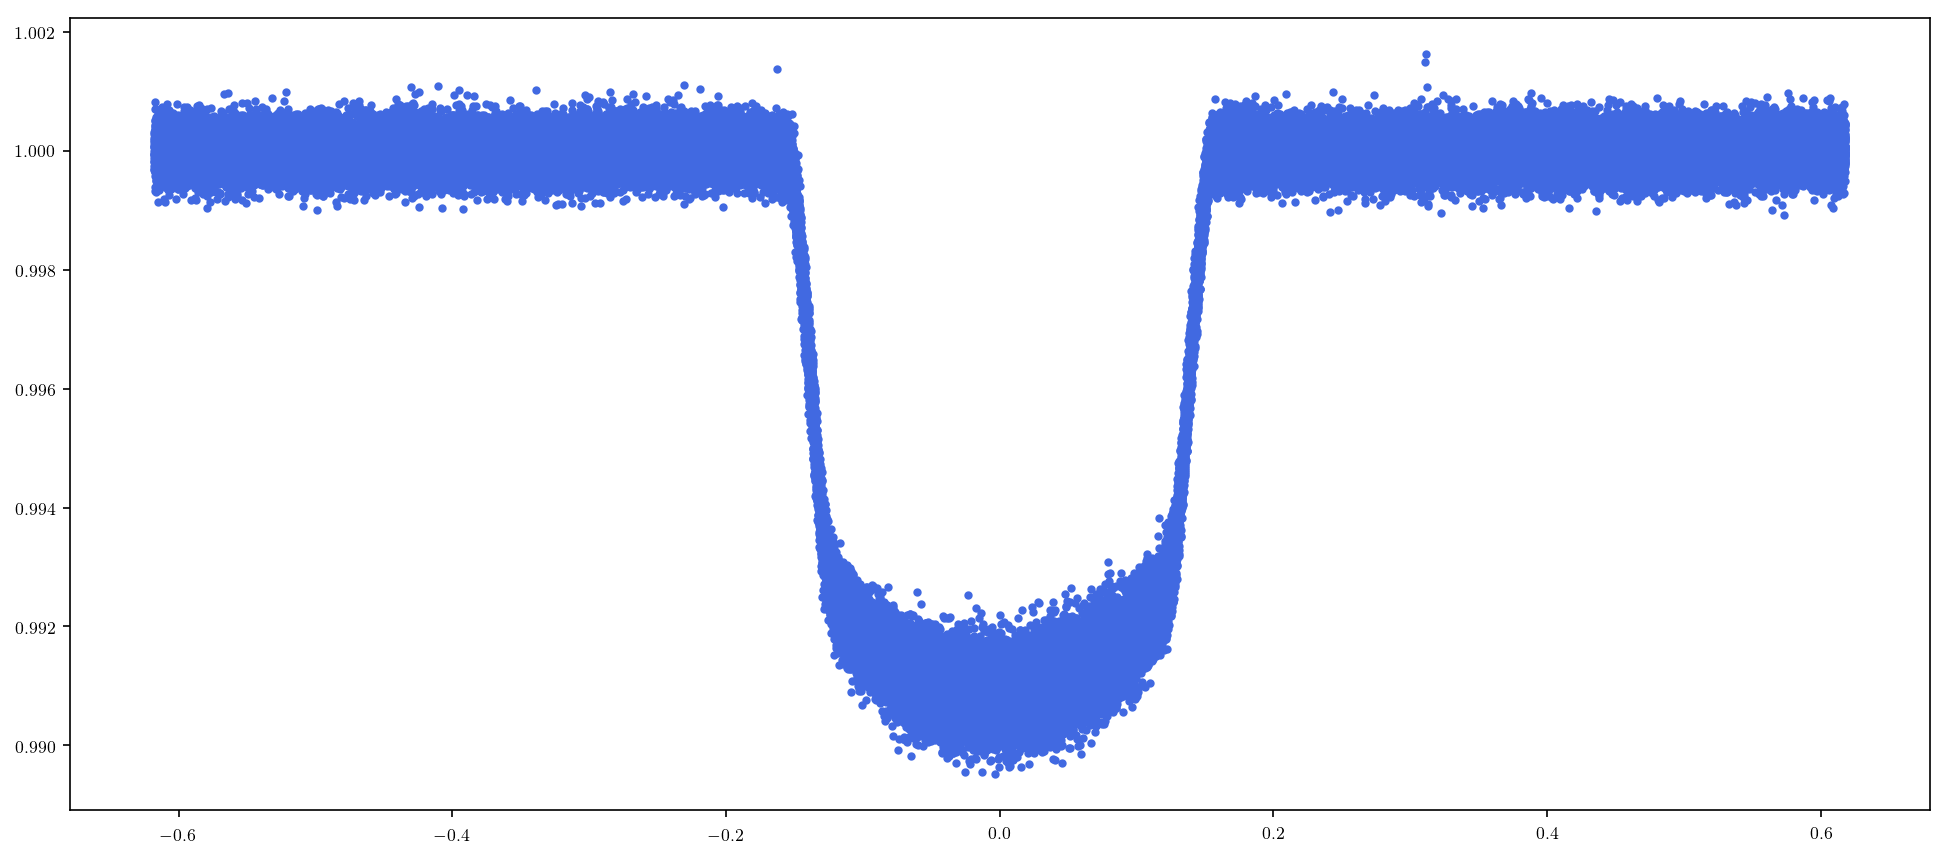

In [30]:
for target in targets:
    if target.kepid == 5812701:
        bad_tr = [65, 49, 23]
        min_flux = []
        target.ind_missed_transits.extend(bad_tr)
        missed_trans = set(target.ind_missed_transits)
        print(target.ind_missed_transits)
        for i in range(len(target.transit_times)): 
            if i not in missed_trans:
                plt.plot(target.ttrans[target.trans_id==i]-target.transit_times[i], target.ftrans[target.trans_id==i],'.', 
                       color = 'royalblue')
                min_flux.append(min(target.ftrans[target.trans_id==i]))
        target.min_flux_folded = min(min_flux)
        print(target.min_flux_folded)

# Fit of the Stellar Density

## Transit Routine

A Python library for generating light curves of transiting planets. See https://github.com/dfm/transit/blob/master/transit/transit.py for original code

In [ ]:
def lnprior_rho(theta, maxb):
    pdepth, pb, sigma, pradius, f0, ptc, sumLD = theta 
    if ((0.3 < sumLD < 1.0) and (0 <= pb <= maxb) and (0 <= sigma)\
         and (pradius > 0) and (pdepth > 0) and (ptc**2<0.01)):
        return 0.0
    return -np.inf  

def lnlike_rho(theta, timeLC, fluxLC, errorLC, allfixed):
    ecc,  mass, masserr, tKep, maxb, P, diffLD = allfixed
    pdepth, pb, sigma, pradius, f0, ptc, sumLD = theta 
    u1 = 0.5*(sumLD+diffLD) 
    u2 = sumLD-u1
    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass = mass, radius = pradius))
    body = transit.Body(radius=np.sqrt(pdepth)*pradius, period=P, t0=ptc, b=np.abs(pb), e=ecc)
    s.add_body(body)
    inv_sigma2 = 1.0/(errorLC**2 + sigma**2)
    try: 
        ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=5)
    except ValueError:
        return -np.inf
    ftheo = ftheo-1+f0
    chi2 = -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)))
    return chi2
                 
def lnprob_rho(theta, timeLC, fluxLC, errorLC, allfixed):
    ecc, mass, masserr, tKep, maxb, P, diffLD = allfixed
    lp_rho = lnprior_rho(theta, maxb)
    if not np.isfinite(lp_rho):
        return -np.inf
    return lp_rho + lnlike_rho(theta, timeLC, fluxLC, errorLC, allfixed)

## MCMC

In [ ]:
def fit_rho(star, t, f, ferr, num_trans, showLC, showMCMC):
    #**************************************** Optimize LC Parameters ****************************************
    max_b = 1+star.rp_solarRad/star.rs
    print("\nMax b (Rp in Solar Radius): {0:0.3f}".format(max_b))
    allfixed_rho = np.array([star.eccen, star.smass, 0.0, tKep, max_b, star.P, star.diffld])
    first_guess =  np.array([star.depth/1.1, star.b, 0.0, star.rs, 1.0, 0.0, (star.u1+star.u2)])
    
    nll_rho = lambda *args: -lnprob_rho(*args)
    result = op.minimize(nll_rho, first_guess, args=(t, f, ferr, allfixed_rho), 
                       options={'maxiter':1e5,'disp': True},
                       method='Nelder-Mead') 
    depth_ml, b_ml, sigma_ml, radius_ml, f0_ml, tc_ml, sumLD_ml = result["x"]
    # Readjust LD coefficients. 
    u1_ml = 0.5*(sumLD_ml + star.diffld)
    u2_ml = sumLD_ml - u1_ml
   
    #Compute the theoretical light curve integrated over a Kepler short-cadence exposure time.
    s = transit.System(transit.Central(mu1=u1_ml, mu2= u2_ml, mass=star.smass, radius=radius_ml))
    body = transit.Body(radius=np.sqrt(depth_ml)*radius_ml, period = star.P, 
                        t0 = tc_ml, b = np.abs(b_ml), e = star.eccen)
    s.add_body(body)
    t_fit = np.arange(-1, 1, tKep*0.01)
    f_fit = s.light_curve(t_fit, texp=tKep, tol=1e-08, maxdepth=5)
    f_fit = f_fit - 1.0 + f0_ml
    if showLC == True:
        fig = plt.figure(figsize=(16,7))
        plt.title(str(star.kepid)+'. Stellar Density Fit for Transit '+str(num_trans+1), fontsize = 15)
        plt.plot(t, f, '.')
        plt.plot(t_fit, f_fit, color='r', lw = 3)
        plt.xlabel('Time from midtransit [days]')
        plt.ylabel('Normalized flux')
        plt.xlim([min(t),max(t)]) 
        plt.show(block=False)    
        time.sleep(0.2)
        plt.close()
    
    #**************************************** MCMC ****************************************
    ndim_rho = len(result["x"])
    p0 = [result["x"]*(1+1e-8*np.random.randn(ndim_rho)) for i in range(nwalkers_rho)]
    
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers_rho, ndim_rho, lnprob_rho, args=(t, f, ferr, allfixed_rho), pool=pool)
        start = time.time()
        print("Running burn-in")
        pos, prob, state = sampler.run_mcmc(p0, 200, progress = True);
        sampler.reset() # Reset the chain to remove the burn-in samples.
        print("\n------ Run MCMC -------")
        sampler.run_mcmc(p0, steps_rho, rstate0 = state, progress=True);
        end = time.time()
        multi_time = end - start
        print("Multiprocessing took {0:.1f} seconds".format(multi_time))
        
    samples = sampler.chain[:, burnin_rho:, :].reshape((-1, ndim_rho))
    samples[:, 2] = np.exp(samples[:, 2])
    
    #Get the 50% percentile and the +- 1 sigma error of the parameters and 2 derived quantities 
    depth_mcmc, b_mcmc, sigma_mcmc, \
    rs_mcmc, f0_mcmc, tc_mcmc, sumLD_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                               zip(*np.percentile(samples, [15.86, 50, 84.14], axis=0)))
    # Readjust LD coefficients. 
    u1_mcmc = 0.5*(sumLD_mcmc[0] + star.diffld)
    u2_mcmc = sumLD_mcmc[0] - u1_mcmc

    if showMCMC == True:
        print("\n------ Post-MCMC Results ------")
        print("\nDepth:\n\tTrue = {:0.3f}".format(star.depth))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(depth_mcmc[0],depth_mcmc[1],depth_mcmc[2]))
        print("\nImpact parameter:\n\tTrue = {:0.3f}".format(star.b))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(b_mcmc[0],b_mcmc[1],b_mcmc[2]))
        print("\nStellar radius [Rsun]:\n\tREPORTED = {:0.3f}".format(star.rs))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(rs_mcmc[0], rs_mcmc[1],rs_mcmc[2]))
        print("\nSum LD Coefficients:\n\tREPORTED = {:0.3f}".format(star.u1+star.u2))
        print("\tu1 MCMC Fit  = {0:0.3f}".format(u1_mcmc))
        print("\tu2 MCMC Fit  = {0:0.3f}".format(u2_mcmc))
        
    #****************************************  Plot MCMC fit **************************************** 
    s = transit.System(transit.Central(mu1=u1_mcmc, mu2=u2_mcmc, mass=star.smass, radius=rs_mcmc[0]))
    body = transit.Body(radius=np.sqrt(depth_mcmc[0])*rs_mcmc[0], period=star.P, t0=tc_mcmc[0], 
                        b=np.abs(b_mcmc[0]), e = star.eccen)
    s.add_body(body)
    t_fit = np.arange(-1, 1, tKep*0.01)
    f_fit = s.light_curve(t_fit, texp=tKep, tol=1e-08, maxdepth=4)
    f_fit = f_fit - 1.0 + f0_mcmc[0]
    fig_lc = plt.figure(figsize=(15,4))
    plt.title('MCMC Fit for KID'+str(star.kepid))
    plt.plot(t, f, '.')
    plt.plot(t_fit, f_fit, 'r', lw = 3)
    plt.xlabel('Time [d]'); plt.ylabel('Normalized Flux')
    plt.xlim([min(t),max(t)])
    filepath_rho = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/new_rs/'
    store_lcfit = "fit"+str(star.kepid)+"_st"+str(steps_rho)+"_trans"+str(num_trans+1)+".png"
    fig_lc.savefig(filepath_rho+store_lcfit)
    plt.close(fig_lc)
    
    #**************************************** Corner Plot **************************************** 
    true_params = [star.depth, star.b, None, star.rs, 1.0, 0.0, (star.u1+star.u2)]
    res_labels = [r'Depth', r'$b$', r'$\sigma$', r'$R_{s} [R_{\odot}]$', r'$f_{0}$', r'$t_{c}$', r'$u_{1}+u_{2}$']
    
    fig_corner = corner.corner(samples, weights = None, labels = res_labels, quantiles = [0.16, 0.5, 0.84],
                               truths = None, show_titles = True, title_args = {"fontsize": 12}, 
                               plot_contours = True, plot_datapoints = False) 
    
    plt.suptitle("KID"+str(star.kepid)+". Corner Plot for Transit "+str(num_trans+1), fontsize = 20)
    store_corner = "corner"+str(star.kepid)+"_st"+str(steps_rho)+"_trans"+str(num_trans+1)+".png"
    fig_corner.savefig(filepath_rho+store_corner)
    plt.close(fig_corner)
   
    #**************************************** Steps Plot **************************************** 
    fig_steps, axes = plt.subplots(ndim_rho, 1, sharex=True, figsize=(8, 9))
    axes[0].plot(sampler.chain[:, :, 0].T, ls='dotted', color = "xkcd:sky blue") #depth = 0
    axes[0].set_ylabel(r'Depth'); 
    axes[0].axhline(true_params[0], color='red')
    axes[1].plot(sampler.chain[:, :, 1].T, ls='dotted', color="xkcd:sky blue")
    axes[1].set_ylabel(r'$b$'); 
    axes[1].axhline(true_params[1], color='red')
    axes[2].plot((sampler.chain[:, :, 2]).T, ls='dotted', color="xkcd:sky blue")
    axes[2].set_ylabel(r'$\sigma$');
    axes[3].plot((sampler.chain[:, :, 3]).T, ls='dotted', color="xkcd:sky blue")
    axes[3].set_ylabel(r'$R_{s} [R_{\odot}]$'); 
    axes[3].axhline(true_params[3], color='red')
    axes[4].plot((sampler.chain[:, :, 4]).T, ls='dotted', color="xkcd:sky blue")
    axes[4].set_ylabel(r'$f_{0}$'); 
    axes[4].axhline(true_params[4], color='red')
    axes[5].plot((sampler.chain[:, :, 5]).T, ls='dotted',color="xkcd:sky blue")
    axes[5].set_ylabel(r"$t_{c}$"); 
    axes[5].axhline(true_params[5], color='red')
    axes[6].plot((sampler.chain[:, :, 6]).T, ls='dotted',color="xkcd:sky blue")
    axes[6].set_ylabel(r"$u_{1}+u_{2}$"); 
    axes[6].axhline(true_params[6], color='red')
    axes[6].set_xlabel("Step number")
    
    fig_steps.tight_layout(h_pad=0.0)
    store_steps= "steps"+str(star.kepid)+"_st"+str(steps_rho)+"_trans"+str(num_trans+1)+".png"
    fig_steps.savefig(filepath_rho+store_steps)
    plt.close(fig_steps)
    
    #**************************************** Acceptance Fraction **************************************** 
    #As rule of thumb, the acceptance fraction (af) should be between 0.2 and 0.5. If af < 0.2 decrease the 
    #a parameter. If af > 0.5 increase the a parameter. 
    af = sampler.acceptance_fraction  
    af_percentage = 100*np.mean(sampler.acceptance_fraction)
    print("Mean acceptance fraction: {0:0.2f} ({1:0.2f} %)".format(np.mean(af), af_percentage))
    
    #**************************************** Store MCMC results **************************************** 
    results_mcmc = [depth_mcmc, b_mcmc, sigma_mcmc, rs_mcmc, f0_mcmc, tc_mcmc, sumLD_mcmc]
    rs_results = np.array([rs_mcmc[0],rs_mcmc[1],rs_mcmc[2]])
    
    return radius_ml, rs_results, af_percentage

## Fit individual Transits

Fit the stellar radius to obtain a better estimate of the stellar density

In [ ]:
for target in targets:
    print("\n******************************** KID"+str(target.kepid)+" ********************************")
    plt.close("all")
    key = target.kepid
    missed_trans = set(target.ind_missed_transits)
    rs_trans_fit = []
    rs_trans_afrac = []
    
    for i in range(len(target.transit_times)): 
        if i not in missed_trans:
            print("\n*TRANSIT "+str(i+1))
            dt_i = target.ttrans[target.trans_id==i]-target.transit_times[i]
            f_trans_i = target.ftrans[target.trans_id==i]
            oot = np.abs(dt_i)>=(target.duration/2)
            iit = np.abs(dt_i)<(target.duration/2)
            d = 1-np.mean(f_trans_i[iit])
            error_trans_oot = np.std(f_trans_i[oot])
            snr = d/error_trans_oot
            print("\tSignal = {0:0.5f}. Noise (rms) = {1:0.5f}. SNR = {2:0.5f}".format(d, error_trans_oot, snr))
            print("\tOut-of-transit error of the transit LC = {0:0.5f}".format(error_trans_oot))
            
            if snr > snr_limit:
                rsFit, rsMCMC, rs_afraction = fit_rho(target, dt_i,  f_trans_i, 0.1*error_trans_oot, i, False, False)
                print("Stellar Radius [Rsun]:\tMCMC = {0:0.5f}.\t1st Fit = {1:0.5f}.\tKepler = {2:0.5f}".format(rsMCMC[0], rsFit, target.rs))
                print("Error Stellar Radius [Rsun]:\tMCMC (up) = {0:0.5f}, (down) = {1:0.5f}.\tOld = {2:0.5f}".format(rsMCMC[1], rsMCMC[2],  target.rs_err))
                rs_trans_fit.append(rsMCMC)
                rs_trans_afrac.append(rs_afraction)
    
    if len(rs_trans_fit) != 0:
        locs_rsNew = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/new_rs/'
        fname_rsNew = str(target.kepid)+"_st"+str(steps_rho)+"_RsMCMC.txt"
        np.savetxt(locs_rsNew+fname_rsNew, np.column_stack((rs_trans_fit, rs_trans_afrac)), 
                               fmt = "%0.3f", header = header_rs)

## Update Rs

Update stellar radius.

In [31]:
path_newRs = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/new_rs'
os.chdir(path_newRs)

modified_rs = 0
for target in targets:
    for file in glob.glob(str(target.kepid)+"*[!\BAD].txt"):
        print("------------------------KID{0:d}------------------------".format(target.kepid))
        
        data = pd.read_csv(file, delimiter=" ", names = ['Rs', '+err', '-err', 'afrac'],
                           header = 1, na_values = '#N/A')
        
        data_mean = data.mean()
        rs_new = data_mean['Rs']
        rs_err_new = np.sqrt(data_mean['+err']**2+data_mean['-err']**2)
        
        print("\tOld R*: {0:0.3f} ({1:0.3f}) [Rsun]\
        \n\tNew R*: {2:0.3f} ({3:0.3f}) [Rsun]\n".format(target.rs, target.rs_err, 
                                                       rs_new, rs_err_new))
        
        modified_rs += 1 
        target.rs = rs_new
        target.rs_err = rs_err_new  
           
print("The stellar radius has been modified for {0:d} systems.".format(modified_rs))

------------------------KID5383248------------------------
	Old R*: 0.993 (0.050) [Rsun]        
	New R*: 1.193 (0.276) [Rsun]

------------------------KID8156120------------------------
	Old R*: 1.927 (0.096) [Rsun]        
	New R*: 2.167 (0.297) [Rsun]

------------------------KID12365184------------------------
	Old R*: 1.731 (0.087) [Rsun]        
	New R*: 0.552 (0.060) [Rsun]

------------------------KID11449844------------------------
	Old R*: 0.879 (0.044) [Rsun]        
	New R*: 0.722 (0.008) [Rsun]

------------------------KID4742414------------------------
	Old R*: 1.407 (0.070) [Rsun]        
	New R*: 1.968 (0.167) [Rsun]

------------------------KID12403119------------------------
	Old R*: 0.892 (0.045) [Rsun]        
	New R*: 0.975 (0.029) [Rsun]

------------------------KID5812701------------------------
	Old R*: 1.367 (0.068) [Rsun]        
	New R*: 1.683 (0.045) [Rsun]

------------------------KID8866102------------------------
	Old R*: 1.337 (0.067) [Rsun]        
	New

# Global Fit

## Transit Routine

A Python library for generating light curves of transiting planets. See https://github.com/dfm/transit/blob/master/transit/transit.py for original code

In [32]:
def ln_probtrans(P, rstar, mstar):
    alog = (1/3)*np.log(mstar)+(2/3)*np.log(P)  
    prob = np.log(rstar)-alog
    #prob = (-2/3)*np.log(P) #see eq'n 4 in https://arxiv.org/pdf/1805.00956.pdf
    return(prob)

In [33]:
def lnlike_MCMC(theta, timeLC, fluxLC, errorLC, allfixed):
    """
    Calculates the log of the likelihood of the transit model being the right model given the following parameters:
    theta[0] = pdepth = (Rp/Rs)^2 #b=0 centre of stellar disk & b=1 at the cusp of the disc
    theta[1] = pb = the mean impact parameter, measured in stellar radii (not Solar radii). See documentation.
    theta[2] = sigma = an additional white noise term
    theta[3] = pmass = the mass of the star (controlled via gaussian prior)
    theta[4] = pradius = the radius of the star (controlled via gaussian prior)
    theta[5] = f0 = the out of eclipse flux
    theta[6] = pperiod = Orbital period 
    theta[7] = ptc = Transit time (time of conjunction) 
    
    Note: pmass and prad (stellar mass and radius) controlled via gaussian prior. 
    By letting M* and R* be free parameters in the model, we allow the stellar density to fluctuate. 
    """
    ecc, mass, masserr, radius, radiuserr, tKep, u1, u2, maxb = allfixed
    pdepth, pb, sigma, pmass, pradius, f0, pperiod, ptc = theta 
    
    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass = pmass, radius = pradius))
    body = transit.Body(radius=np.sqrt(pdepth)*pradius, period=pperiod, t0=ptc, b=np.abs(pb), e=ecc)
    s.add_body(body)
    inv_sigma2 = 1.0/(errorLC**2 + sigma**2)
    
    try: 
        ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=4)
    except ValueError:
        return -np.inf
    
    ftheo = ftheo-1+f0
    
    return -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)) + ((pmass-mass)/masserr)**2
            + ((pradius-radius)/radiuserr)**2)

In [34]:
"""
def lnprior(theta, maxb):
    ##https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations
    pdepth, pb, sigma, pmass, pradius, f0, pperiod, ptc = theta
    if ((0 <= pb <= maxb) and (0 <= sigma) and (pradius > 0) 
        and (pdepth > 0) and (pmass > 0.0) and (13.5 <= pperiod)  and (ptc**2<0.01)):
        return ln_probtrans(pperiod, pradius, pmass)
    return -np.inf  
"""
def lnprior_MCMC(theta, maxb): ##https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations
    pdepth, pb, sigma, pmass, pradius, f0, pperiod, ptc = theta
    if ((0 <= pb <= maxb) and (0 <= sigma) and (pradius > 0) 
        and (pdepth > 0) and (pmass > 0.0) and (13.5 <= pperiod)  and (ptc**2<0.01)):
        return ln_probtrans(pperiod, pradius, pmass) 
    return -np.inf    

In [35]:
"""
def lnprob(theta, timeLC, fluxLC, errorLC, allfixed):
    ecc, mass, masserr, radius, radiuserr, tKep, u1, u2, maxb = allfixed
    lp = lnprior(theta, maxb)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_mcmc(theta, timeLC, fluxLC, errorLC, allfixed)
"""

def lnprob_MCMC(theta, timeLC, fluxLC, errorLC, allfixed_MCMC):
    ecc, mass, masserr, radius, radiuserr, tKep, u1, u2, maxb = allfixed_MCMC
    lp_MCMC = lnprior_MCMC(theta, maxb)
    if not np.isfinite(lp_MCMC):
        return -np.inf
    return lp_MCMC + lnlike_MCMC(theta, timeLC, fluxLC, errorLC, allfixed_MCMC)

In [36]:
def run_transit_routine(star, t, f, ferr, transit_num, showLC):
    #depth_guess = 1-min(f)
    depth_guess = 1-target.min_flux_folded
    rp_guess = np.sqrt(depth_guess)*star.rs
    max_b = 1+rp_guess/star.rs
   
    print("\nMin flux Folded LC = {0:0.6f}".format(target.min_flux_folded))
    print("Min flux individual transit = {0:0.6f}".format(min(f)))
    print("Max. allowed b (1+rp_guess/rs) = {0:0.6f}".format(max_b))
    print("Depth guess = {0:0.6f}. True depth = {1:0.6f}".format(depth_guess, star.depth))
    
    allfixed_MCMC = np.array([star.eccen, star.smass, star.smass_err, star.rs, star.rs_err, tKep, star.u1, star.u2, max_b])
    
    nll_MCMC = lambda *args: -lnprob_MCMC(*args)
    
    res0 = op.minimize(nll_MCMC, [depth_guess/1.2, 0.4, 0.0, star.smass, star.rs, 1.0, period_guess, 0.0], 
                       args=(t, f, 0.0, allfixed_MCMC), 
                       options={'maxiter': 1e5, 'disp': True},
                       method='Nelder-Mead') #options={'maxiter': 1e3, 'disp': True}
    
    res1 = op.minimize(nll_MCMC, res0["x"], args=(t, f, ferr, allfixed_MCMC), 
                       options={'maxiter': 1e5, 'disp': True},
                       method='Nelder-Mead')
    
    depth_ml, b_ml, sigma_ml, mass_ml, radius_ml, f0_ml, period_ml, tc_ml = res1["x"]
        
    # Compute the theoretical light curve integrated over a Kepler short-cadence exposure time.
    s = transit.System(transit.Central(mu1=star.u1, mu2=star.u2, mass=mass_ml, radius=radius_ml))
    body = transit.Body(radius=np.sqrt(depth_ml)*radius_ml, period=period_ml, t0=tc_ml, b=np.abs(b_ml), e=star.eccen)
    s.add_body(body)
    t_fit = np.arange(-1, 1, tKep*0.01)
    f_fit = s.light_curve(t_fit, texp=tKep, tol=1e-08, maxdepth=4)
    f_fit = f_fit-1.0+f0_ml
    
    if showLC == True:
        fig = plt.figure(figsize=(16,5))
        plt.title("KID"+str(star.kepid)+". Preliminary Fit for Transit "+str(transit_num+1), fontsize = 15)
        plt.plot(t, f, '.', label = 'Kepler data')
        plt.plot(t_fit, f_fit, color='r', lw = 3, label = 'Fit')
        plt.xlabel('Time from midtransit [days]')
        plt.ylabel('Normalized flux')
        plt.xlim([min(t),max(t)]) 
        plt.show(block=False)    
        time.sleep(0.1)
        plt.close()

    #star.duration = body.duration #from eq'n 14 in Winn (2010)
    print("------ Pre-MCMC Results ------")
    print("\tTransit duration [d]:\t Fit={0:0.3f}\tTrue={1:0.3f}".format(body.duration, star.duration))
    print("\tPeriod [days]:\t Fit={0:0.8f}\tTrue={1:0.8f}".format(period_ml,star.P))
    print("\tImpact Parameter:\t Fit={0:0.6f}\tTrue={1:0.6f}".format(b_ml,star.b))
    print("\tDepth:\t Fit={0:0.6f}\tTrue={1:0.6f}".format(depth_ml,star.depth))
    print("\tStellar mass:\t Fit={0:0.3f}\tTrue={1:0.3f}".format(mass_ml,star.smass))
    print("\tStellar radius:\t Fit={0:0.3f}\tTrue={1:0.3f}".format(radius_ml,star.rs))
    print("\tSigma (white noise):\t Fit={0:0.5f}".format(sigma_ml))
    print("\tOut-of-transit flux:\t Fit={0:0.3f}".format(f0_ml))
    
    return(res1["x"])

## MCMC 

In [37]:
def run_mcmc(star, t, f, ferr, num_trans, fit_results, show_mcmc_res):
    
    depth_ml, b_ml, sigma_ml, mass_ml, radius_ml, f0_ml, period_ml, tc_ml = fit_results
    
    #adjust depth a little
    fit_results[0] = fit_results[0]/1.1
    rp_guess = np.sqrt(fit_results[0])*radius_ml
    maxb = 1+rp_guess/radius_ml
        
    print("\n------------------ Prepare MCMC ------------------")
    print("Guess impact parameter: {0:0.5f}".format(fit_results[1]))
    print("Guess of Rp [in Rsun]: {0:0.5f}".format(rp_guess))
    print("Max. allowed b (1+rp_guess/rs): {0:0.5f}".format(maxb))

    allfixed_MCMC = [star.eccen, star.smass, star.smass_err, star.rs, star.rs_err, tKep, star.u1, star.u2, maxb]
    
    #**************************************** MCMC ****************************************
    ndim = len(fit_results)
    p0 = [fit_results*(1+1e-8*np.random.randn(ndim)) for i in range(nwalkers)]
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_MCMC, args=(t, f, ferr, allfixed_MCMC), pool=pool)
        start = time.time()
        print("\nRunning burn-in")
        pos, prob, state = sampler.run_mcmc(p0, 200, progress=True);
        sampler.reset() # Reset the chain to remove the burn-in samples.
        print("\n------ Run MCMC -------")
        sampler.run_mcmc(p0, steps, rstate0 = state, progress=True);
        end = time.time()
        multi_time = end - start
        print("Multiprocessing took {0:.1f} seconds".format(multi_time))
   
    samples = sampler.chain[:, burnin_global:, :].reshape((-1, ndim)) 
    
    #Clipping extreme values (top.bottom 0.1 percentiles)
    #toclip=np.array([(np.percentile(samples[:,t],99.9)>samples[:,t]) // (samples[:,t]>np.percentile(samples[:,t],0.1)) for t in range(ndim)]).all(axis=0)
    #samples=samples[toclip]
    
    """
    !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #************ BE CAREFUL WITH THE INDEXES OF THE FOLLOWING FOUR LINES!!!!! ************
    !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    """
    
    #This is bc the indexes depend on the list of parameters being fitted.
    period_distribution = samples[:,6]
    samples[:, 2] = np.exp(samples[:, 2])
    planetradsamp = 109.045*np.sqrt(samples[:,0])*samples[:, 4] #in EARTH RAD rad( rp = sqrt(depth)*rs)
    P1 = period_ml*24.0*3600.0 #in sec
    r_asamp = ((3.0*np.pi/(G*P1**2))*((samples[:,4]**3/samples[:, 3])/1408.0))**0.3333

    #Get the 50% percentile and the +- 1 sigma error of the parameters and 2 derived quantities 
    depth_mcmc, b_mcmc, sigma_mcmc, smass_mcmc, rs_mcmc, \
    f0_mcmc, period_mcmc, tc_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                               zip(*np.percentile(samples, [15.86, 50, 84.14], axis=0)))
    
    v = np.percentile(planetradsamp, [15.86, 50, 84.14], axis=0)
    planetrad_mcmc =(v[1], v[2]-v[1], v[1]-v[0])
    v = np.percentile(r_asamp, [15.86, 50, 84.14], axis=0)
    r_a_mcmc =(v[1], v[2]-v[1], v[1]-v[0])
    
    results_mcmc = [depth_mcmc, b_mcmc, sigma_mcmc, smass_mcmc, rs_mcmc, f0_mcmc, 
                    period_mcmc, tc_mcmc, planetrad_mcmc, r_a_mcmc]
    
    if show_mcmc_res == True:
        print("\n------------------ Post-MCMC Results ------------------")
        print("\nDepth:\n\tTrue = {:0.3f}".format(star.depth))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(depth_mcmc[0],depth_mcmc[1],depth_mcmc[2]))
        print("\nImpact parameter:\n\tTrue = {:0.3f}".format(star.b))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(b_mcmc[0],b_mcmc[1],b_mcmc[2]))
        print("\nPlanet radius [REarth]:\n\tTrue = {:0.3f}".format(star.rp)) #In earth radii due to the conversion done above 
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(planetrad_mcmc[0],planetrad_mcmc[1],planetrad_mcmc[2]))
        print("\nPeriod [d]:\n\tTrue = {:0.3f}".format(star.P))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(period_mcmc[0],period_mcmc[1],period_mcmc[2]))
        print("\nInverse of scaled semi-major axis:\n\tTrue = {:0.4f}".format(1/star.dor))
        print("\tMCMC Fit = {0:0.4f} (+{1:0.4f},-{2:0.4f})".format(r_a_mcmc[0],r_a_mcmc[1],r_a_mcmc[2]))
        print("\nStellar radius [Rsun]:\n\tTrue = {:0.3f}".format(star.rs))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(rs_mcmc[0],rs_mcmc[1],rs_mcmc[2]))
        print("\nStellar Mass [Msun]:\n\tTrue = {:0.3f}".format(star.smass))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(smass_mcmc[0],smass_mcmc[1],smass_mcmc[2]))

    #****************************************  Plot MCMC fit **************************************** 
    s = transit.System(transit.Central(mu1=star.u1, mu2=star.u2, mass=smass_mcmc[0], radius=rs_mcmc[0]))
    body = transit.Body(radius=np.sqrt(depth_mcmc[0])*rs_mcmc[0], period=period_mcmc[0],
                        t0=tc_mcmc[0], b=np.abs(b_mcmc[0]), e=star.eccen)
    s.add_body(body)
    t_fit = np.arange(-1.5, 1.5, tKep*0.01)
    f_fit = s.light_curve(t_fit, texp=tKep, tol=1e-08, maxdepth=4)
    f_fit = f_fit - 1.0 + f0_mcmc[0]
    fig_lc = plt.figure(figsize=(15,4))
    plt.title('MCMC Fit for KID'+str(star.kepid))
    plt.plot(t, f, '.', label = 'kepler')
    plt.plot(t_fit, f_fit, 'r', lw = 3, label = 'fit')
    plt.xlabel('Time [d]'); plt.ylabel('Normalized Flux')
    plt.xlim([min(t),max(t)]); 
    file_path_fit = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/MCMC_fits/'
    store_mcmc_fit = "fit"+str(star.kepid)+"_st"+str(steps)+"_trans"+str(num_trans+1)+"_"+str(period_guess)+"d.png"
    fig_lc.savefig(file_path_fit+store_mcmc_fit)
    plt.close(fig_lc)
        
    #**************************************** Corner Plot **************************************** 
    true_params = [star.depth, star.b, None, star.smass, star.rs, 1.0, star.P, 0.0]
    res_labels = ['Depth', 'b', r'$\sigma$', r'$M_{*} [M_{\odot}]$', r'$R_{*} [R_{\odot}]$', 
              r'$f_{0}$', 'P [d]', r'$t_c$']
    fig_corner = corner.corner(samples, weights = None, labels = res_labels, quantiles=[0.16, 0.5, 0.84],
                               truths = true_params, show_titles = True, title_args={"fontsize": 12}, 
                               plot_contours=True, truth_color='r', plot_datapoints=False)
    
    plt.suptitle('Corner Plot for KID'+str(star.kepid), fontsize = 20)
    file_path = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/corner/'
    store_corner = "corner"+str(star.kepid)+"_st"+str(steps)+"_trans"+str(num_trans+1)+"_"+str(period_guess)+"d.png"
    fig_corner.savefig(file_path+store_corner)
    plt.close(fig_corner)
   
    #**************************************** Acceptance Fraction **************************************** 
    #As rule of thumb, the acceptance fraction (af) should be between 0.2 and 0.5. If af < 0.2 decrease the 
    #a parameter. If af > 0.5 increase the a parameter. 
    af = sampler.acceptance_fraction  
    af_percentage = 100*np.mean(sampler.acceptance_fraction)
    print("\nMean acceptance fraction: {0:0.2f} ({1:0.2f} %) ".format(np.mean(af), af_percentage))
    
    #**************************************** Steps Plot **************************************** 
    fig_b, axes = plt.subplots(8, 1, sharex=True, figsize=(8, 9))
    axes[0].plot(sampler.chain[:, :, 0].T, ls='dotted', color = "xkcd:sky blue") 
    axes[0].set_ylabel(r'Depth'); 
    axes[0].axhline(true_params[0], color='red')
    axes[1].plot(sampler.chain[:, :, 1].T, ls='dotted', color="xkcd:sky blue")
    axes[1].set_ylabel(r'$b$'); 
    axes[1].axhline(true_params[1], color='red')
    axes[2].plot((sampler.chain[:, :, 2]).T, ls='dotted', color="xkcd:sky blue")
    axes[2].set_ylabel(r'$\sigma$');
    axes[3].plot((sampler.chain[:, :, 3]).T, ls='dotted', color="xkcd:sky blue")
    axes[3].set_ylabel(r'$M_{*} [M_{\odot}]$'); 
    axes[3].axhline(true_params[3], color='red')
    axes[4].plot((sampler.chain[:, :, 4]).T, ls='dotted', color="xkcd:sky blue")
    axes[4].set_ylabel(r'$R_{*} [R_{\odot}]$'); 
    axes[4].axhline(true_params[4], color='red')
    axes[5].plot((sampler.chain[:, :, 5]).T, ls='dotted', color="xkcd:sky blue")
    axes[5].set_ylabel('$f_{0}$'); 
    axes[5].axhline(true_params[5], color='red')
    axes[6].plot((sampler.chain[:, :, 6]).T, ls='dotted',color="xkcd:sky blue")
    axes[6].set_ylabel("$P [d]$"); 
    axes[6].axhline(true_params[6], color='red')
    axes[7].plot((sampler.chain[:, :, 7]).T, ls='dotted',color="xkcd:sky blue")
    axes[7].set_ylabel("$t_{c}$");
    axes[7].set_xlabel("Step number")
    fig_b.tight_layout(h_pad=0.0)
    filepath = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/burnin/'
    store_steps= "steps"+str(star.kepid)+"_st"+str(steps)+"_trans"+str(num_trans+1)+".png"
    fig_b.savefig(filepath+store_steps)
    plt.close(fig_b)
    
    return (period_distribution, results_mcmc)

## Transit Analysis

As a reminder, your MCMC parameters are set to: 

In [42]:
steps, nwalkers, burnin_global

(10000, 100, 2000)

You've also chosen that:

In [43]:
print("SNR limit per transit: {0:0.2f} [d]".format(snr_limit))
print("LC baseline amplification: {0:0.1f}".format(amplify))
print("Period guess: {0:0.2f} [d]".format(period_guess))

SNR limit per transit: 3.00 [d]
LC baseline amplification: 2.0
Period guess: 30.00 [d]


Fit each transit with the new stellar density


******************************** KID11133306 ********************************

*TRANSIT 1
	Signal = 0.00038. Noise (rms) = 0.00030. SNR = 1.27823
	Out-of-transit error of the transit LC = 0.00030

*TRANSIT 2
	Signal = 0.00039. Noise (rms) = 0.00029. SNR = 1.34154
	Out-of-transit error of the transit LC = 0.00029

*TRANSIT 3
	Signal = 0.00036. Noise (rms) = 0.00028. SNR = 1.25945
	Out-of-transit error of the transit LC = 0.00028

*TRANSIT 4
	Signal = 0.00034. Noise (rms) = 0.00028. SNR = 1.21716
	Out-of-transit error of the transit LC = 0.00028

*TRANSIT 5
	Signal = 0.00024. Noise (rms) = 0.00028. SNR = 0.85699
	Out-of-transit error of the transit LC = 0.00028

*TRANSIT 6
	Signal = 0.00032. Noise (rms) = 0.00029. SNR = 1.10424
	Out-of-transit error of the transit LC = 0.00029

*TRANSIT 7
	Signal = 0.00036. Noise (rms) = 0.00028. SNR = 1.26480
	Out-of-transit error of the transit LC = 0.00028

*TRANSIT 8
	Signal = 0.00038. Noise (rms) = 0.00029. SNR = 1.28654
	Out-of-transit error of th

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -7290.217992
         Iterations: 2098
         Function evaluations: 3094
Optimization terminated successfully.
         Current function value: -7290.229117
         Iterations: 301
         Function evaluations: 488


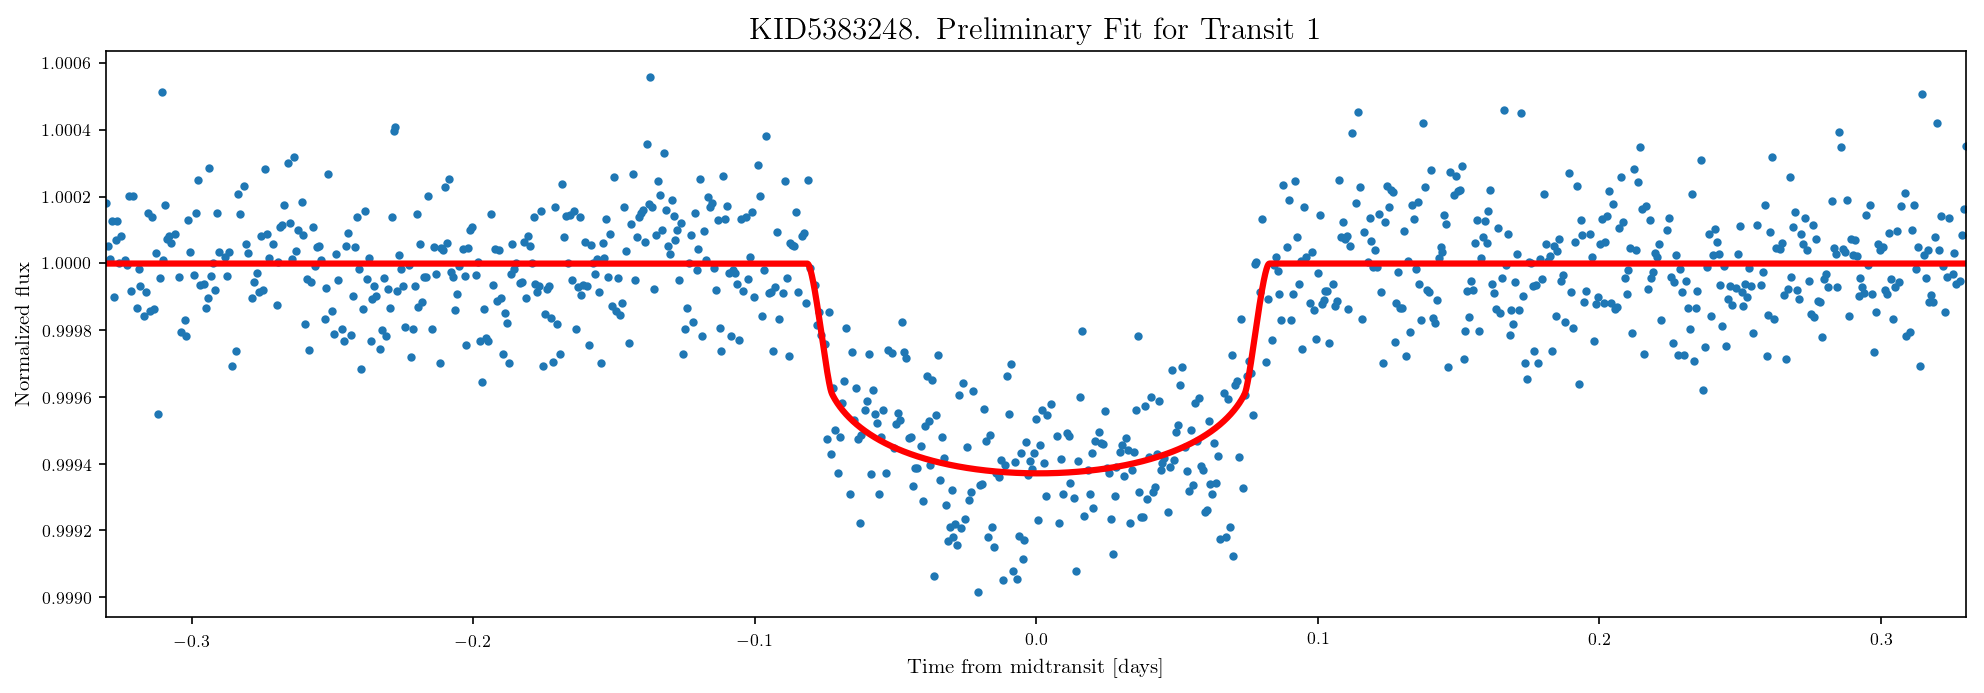

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.164	True=0.165
	Period [days]:	 Fit=13.50001559	True=16.23847733
	Impact Parameter:	 Fit=0.736994	True=0.766000
	Depth:	 Fit=0.000614	True=0.000647
	Stellar mass:	 Fit=0.950	True=0.951
	Stellar radius:	 Fit=1.255	True=1.193
	Sigma (white noise):	 Fit=0.00016
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.73699
Guess of Rp [in Rsun]: 0.02966
Max. allowed b (1+rp_guess/rs): 1.02363


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


100%|██████████| 10000/10000 [04:58<00:00, 33.54it/s]


Multiprocessing took 303.7 seconds

------------------ Post-MCMC Results ------------------

Depth:
	True = 0.001
	MCMC Fit = 0.001 (+0.000,-0.000)

Impact parameter:
	True = 0.766
	MCMC Fit = 0.767 (+0.071,-0.160)

Planet radius [REarth]:
	True = 2.760
	MCMC Fit = 2.866 (+0.675,-0.654)

Period [d]:
	True = 16.238
	MCMC Fit = 24.793 (+19.901,-8.547)

Inverse of scaled semi-major axis:
	True = 0.0469
	MCMC Fit = 0.0447 (+0.0093,-0.0088)

Stellar radius [Rsun]:
	True = 1.193
	MCMC Fit = 1.049 (+0.217,-0.209)

Stellar Mass [Msun]:
	True = 0.951
	MCMC Fit = 0.951 (+0.048,-0.047)

Mean acceptance fraction: 0.21 (20.80 %) 

*TRANSIT 2
	Signal = 0.00054. Noise (rms) = 0.00017. SNR = 3.21174
	Out-of-transit error of the transit LC = 0.00017

Min flux Folded LC = 0.998532
Min flux individual transit = 0.998978
Max. allowed b (1+rp_guess/rs) = 1.038318
Depth guess = 0.001468. True depth = 0.000647


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -7634.654433
         Iterations: 854
         Function evaluations: 1319
Optimization terminated successfully.
         Current function value: -7636.832453
         Iterations: 1697
         Function evaluations: 2559


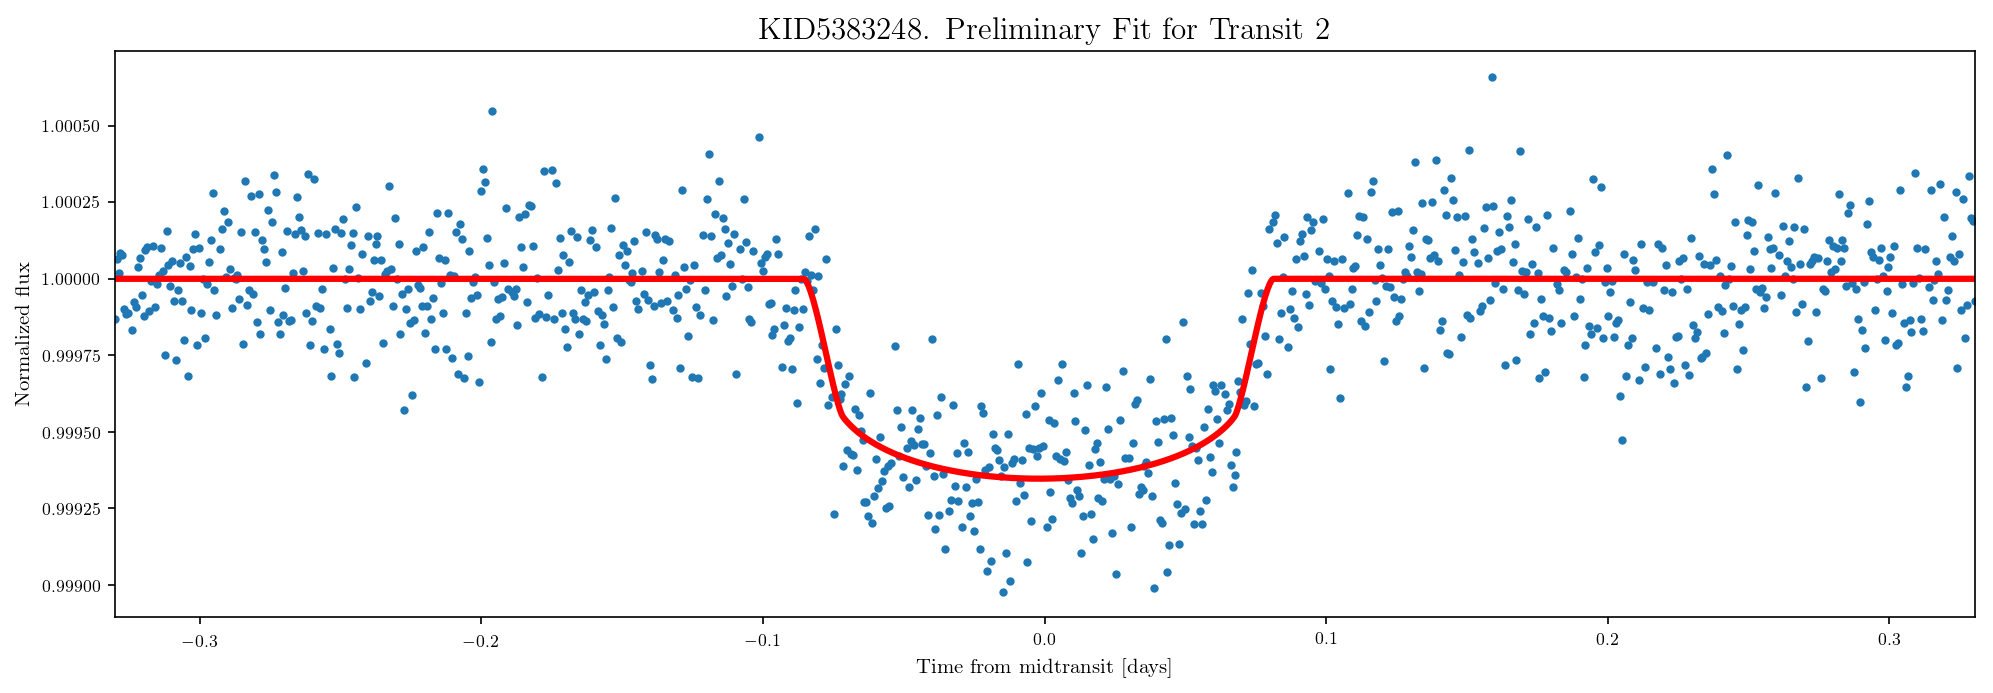

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.167	True=0.165
	Period [days]:	 Fit=19.37118765	True=16.23847733
	Impact Parameter:	 Fit=0.837414	True=0.766000
	Depth:	 Fit=0.000705	True=0.000647
	Stellar mass:	 Fit=0.949	True=0.951
	Stellar radius:	 Fit=1.357	True=1.193
	Sigma (white noise):	 Fit=0.00017
	Out-of-transit flux:	 Fit=1.000

------------------ Prepare MCMC ------------------
Guess impact parameter: 0.83741
Guess of Rp [in Rsun]: 0.03435
Max. allowed b (1+rp_guess/rs): 1.02531


  0%|          | 0/200 [00:00<?, ?it/s]


Running burn-in


  0%|          | 0/10000 [00:00<?, ?it/s]


------ Run MCMC -------


 79%|███████▊  | 7855/10000 [04:00<01:10, 30.44it/s]

In [ ]:
for target in targets:
    print("\n******************************** KID"+str(target.kepid)+" ********************************")
    key = target.kepid
    missed_trans = set(target.ind_missed_transits)
    for i in range(len(target.transit_times)): 
        if i not in missed_trans:
            print("\n*TRANSIT "+str(i+1))
            dt_i = target.ttrans[target.trans_id==i]-target.transit_times[i]
            f_trans_i = target.ftrans[target.trans_id==i]
            oot = np.abs(dt_i)>=(target.duration/2)
            iit = np.abs(dt_i)<(target.duration/2)
            d = 1-np.mean(f_trans_i[iit])
            error_trans_oot = np.std(f_trans_i[oot])
            snr = d/error_trans_oot
            print("\tSignal = {0:0.5f}. Noise (rms) = {1:0.5f}. SNR = {2:0.5f}".format(d, error_trans_oot, snr))
            print("\tOut-of-transit error of the transit LC = {0:0.5f}".format(error_trans_oot))
            
            if  snr > snr_limit:  
                lc_fit = run_transit_routine(target, dt_i, f_trans_i, 0.1*error_trans_oot, i, True)
                period_res, mcmc_res = run_mcmc(target, dt_i, f_trans_i, 0.1*error_trans_oot, i, lc_fit, True)
                locs_P_trans = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/period_distributions/'
                locs_MCMC = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/MCMC_results/'

                fname_P_trans = str(target.kepid)+"_st"+str(steps)+"_Pdist_trans"+str(i+1)+"_"+str(period_guess)+"d.txt"
                fname_MCMC = str(target.kepid)+"_st"+str(steps)+"_MCMCres_trans"+str(i+1)+"_"+str(period_guess)+"d.txt"

                np.savetxt(locs_P_trans+fname_P_trans, np.transpose(period_res), fmt = "%0.15f")
                np.savetxt(locs_MCMC+fname_MCMC, np.column_stack((id_mcmc, mcmc_res)), 
                                       header = header_mcmc, delimiter=" ", fmt="%s")

# Period Analysis

In [ ]:
path_panalysis = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/period_charts/30d/'
path_resMCMC = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/MCMC_results/30d/'
path_pdistr = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/period_distributions/30d/'

In [ ]:
#colors: https://matplotlib.org/examples/color/named_colors.html

def plot_periods(star):
    bin_num = 15
    fig = plt.figure(figsize=(16,14))
    ax=fig.add_subplot(211)
    for i in range(len(star.full_P_trans)):
        ax.hist(star.full_P_trans[i]['Period'], density = True, bins=30, histtype='step', label='Transit '+str(i+1));
    ax.set_title('KID'+str(star.kepid)+' - Transit Period distribution', fontsize = 20)
    plt.axvline(x = star.P, color = 'r', linewidth = 4, label = 'True Period' )
    ax.set_xlabel(r'$P$ [d]')
    ax.set_ylabel('Frequency')
    if (len(star.transit_times) < 10): ax.legend(loc='best', fontsize = 12)

    ax2 = fig.add_subplot(212)
    ax2.set_title('KID'+str(star.kepid)+' - Full Period Distribution', fontsize = 20)
    ax2.hist(star.full_P['Period'], bins=bin_num*3, density = True, color='wheat', alpha = 0.5) 
    ax2.set_xlabel(r'$P$ [d]')
    ax2.set_ylabel('Frequency')
    plt.axvline(x = star.P, color = 'r', linewidth = 4, label = 'True Period')
    plt.axvline(x = star.full_stats['mode'][0], color = 'b', ls = 'dashed', lw = 3, label = 'Mode')
    plt.axvline(x = star.full_stats['mean'][0], color = 'k', ls = 'dashed', lw = 3, label = 'Mean')
    plt.axvline(x = star.full_stats['median'][0], color = 'r',  ls = 'dashed', lw = 3, label = 'Median')
    plt.axvline(x = star.full_stats['16%'][0], color = 'k', ls = ':', lw = 3, label = '16%')
    plt.axvline(x = star.full_stats['50%'][0], color = 'm', ls = ':', lw = 3, label = '50%')
    plt.axvline(x = star.full_stats['84%'][0], color = 'g', ls = ':', lw = 3, label = '84%')
    ax2.legend(loc = 'best', fontsize = 12)
    plt.show()
    plt.tight_layout()
    fig.savefig(path_panalysis+"hist"+str(star.kepid)+".png")
    plt.close(fig)

In [ ]:
def get_statistics(data):
    full_statistics = pd.DataFrame({'mean': data.mean(), 'median': data.median(),'mode': data.mode(),
                        'std': data.std(), 'min': data.min(), 'max': data.max(), 
                   '16%': data.quantile(0.16), '50%': data.quantile(0.5), '84%': data.quantile(0.84)})
    return full_statistics

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def closest_statistic(df, P):
    cols = ['mean', 'median', 'mode']
    stats = [df['mean'], df['median'], df['mode']]
    res = find_nearest(stats, P)
    idx_res = np.where(stats == res)[0][0]
    return cols[idx_res]

def show_best_stats(star):
    df = pd.DataFrame({'Statistics': star.best_stats})
    freq = df['Statistics'].value_counts().to_dict()
    color_by_label = {'median': 'lightcoral', 'mode': 'lightskyblue', 'mean': 'lightgreen'}
    colors = []
    for label in freq.keys():
        colors.append(color_by_label[label])
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(111)
    ax.pie(freq.values(), colors = colors, autopct='%1.2f%%', shadow = False, startangle = 90)
    plt.legend(loc ='best', labels = ['%s: %d%%' % (l, s) for l, s in zip(freq.keys(), freq.values())],shadow=True)
    ax.axis('equal')  
    ax.set_title("KID"+str(star.kepid), fontsize = 15)
    left, bottom, width, height = [0.15, 0.5, 0.2, 0.2] # These are in unitless percentages of the figure size. (0,0 is bottom left)
    axins = fig.add_axes([left, bottom, width, height])
    missed_trans = set(star.ind_missed_transits)
    for i in range(len(target.transit_times)): 
        if i not in missed_trans:
            axins.plot(star.ttrans[star.trans_id==i]-star.transit_times[i],star.ftrans[star.trans_id==i],'.', 
                       color = 'royalblue', ms = 0.3)
    axins.set_xlabel('Time [d]',fontsize = 8)
    axins.set_ylabel('Flux', fontsize = 8)
    axins.set_title('Folded Light Curve', fontsize = 10)
    plt.tight_layout()
    plt.show()
    fig.savefig(path_panalysis+"pie"+str(star.kepid)+".png")
    plt.close(fig)

In [ ]:
os.chdir(path_pdistr)
count = 0
save_best_stats = []

for target in targets:
    period_distribution = []
    P_trans_stats = []
    best_statistics = []
    search_files = glob.glob(path_pdistr+str(target.kepid)+"*[!_BAD].txt")

    if len(search_files) != 0:
        for i in range(len(search_files)):
            filename = search_files[i]
            Ptrans = pd.read_csv(filename, sep = " ", names=['Period'], index_col = None)
            period_distribution.append(Ptrans)
            trans_stats = get_statistics(Ptrans['Period']).iloc[0]
            P_trans_stats.append(trans_stats)
            best_statistics.append(closest_statistic(trans_stats, target.P))
        target.full_P_trans = period_distribution
        target.full_P = pd.concat(period_distribution)
        target.best_stats = best_statistics
        save_best_stats.append(best_statistics)

        #Calculate statistical properties 
        target.full_P_trans_stats = P_trans_stats
        target.full_stats = get_statistics(target.full_P['Period'])
        plot_periods(target)
        show_best_stats(target)
        count += 1

In [ ]:
print(count)
save_best_stats = list(itertools.chain.from_iterable(save_best_stats))

In [ ]:
import seaborn as sns

count_median, count_mean, count_mode = 0, 0, 0


for target in targets:
    getmc = glob.glob(path_resMCMC+str(target.kepid)+"*[!_BAD].txt")
    num_trans = 0
    
    if len(getmc) != 0:
        print("\n--------------------------------KID{0:d}--------------------------------".format(target.kepid))
        
        xtrans = []
        oc, oc_err = [], []
        est_p, est_p_up, est_p_down, est_p_err = [], [], [], []
        
        best_measure = closest_statistic(target.full_stats, target.P)
        best_value = target.full_stats[str(best_measure)].values[0]
        if (best_measure == 'median'): count_median+=1
        elif (best_measure == 'mode'): count_mode+=1
        elif (best_measure == 'mean'): count_mean+=1
        
        for i in range(len(getmc)): 
            filename = getmc[i]
            num_trans += 1
            data = {}
            for line in open(filename):
                if line.startswith("#"):
                    continue
                field_name, values = line.split(":")
                data[field_name] = values.split(" ")
            
            df = pd.DataFrame(data)
            
            #Extract Period information and its +-1 sigma error
            est_p = float(df['Orbital Period (P, [days])'][1]) #this is the median result for each transit
            est_p_up = float(df['Orbital Period (P, [days])'][2]) 
            est_p_down = float(df['Orbital Period (P, [days])'][3]) 
            est_p_err = np.sqrt(est_p_up**2 + est_p_down**2)
            xtrans.append(i+1)
            oc.append(est_p-target.P)
            oc_err.append(est_p_err)
        
        print("True Period: {0:0.3f} [d]".format(target.P))
        print("- Individual Transits:")
        print("\t* Mean Estimated Period (using the median for each transit): {0:0.3f} [d]".format(np.mean(est_p)))
        print("\t* Error of the Mean Estimated Period: {0:0.3f}".format(np.mean(est_p_err)))
        print("\t* std OCs: {0:0.5f} [d]".format(np.std(oc)))
        print("\t* |Mean| OCs: {0:0.3f} [d]".format(np.abs(np.mean(oc))))
        print("- All Transits Considered:")
        print("\t* Best Statistical Measure: {0:s}".format(best_measure))
        print("\t* Best Estimated Period: {0:0.3f} [d]".format(best_value))
        print("\t* Relative difference b/w True and Calc period: {0:0.3f}".format(target.P-best_value))
        
        textstr = 'Mean OC = {0:.2f} d\nstd OC= {1:.5f} d\nEstimated Period = {2:.2f} d\nTrue Period = {3:0.2f} d'.format(np.mean(oc),
                                                                                                np.std(oc), 
                                                                                            np.mean(est_p), target.P)
        
        
        fig = plt.figure(figsize=(12,5))
        ax = fig.add_subplot(111)
        ax.axhline(y = 0, c = 'r', ls= 'dotted', lw=3, label = 'True Period ({0:.2f} d)'.format(target.P))
        ax.errorbar(xtrans, oc, yerr = oc_err, fmt='o')
        
        ax.set_xlabel('Transit number')
        ax.set_ylabel('O-C')
        ax.set_title('Residuals Distribution')
        ax.annotate(textstr, xy=(0.225, 0.73), xycoords='axes fraction',
                    horizontalalignment='right', verticalalignment='bottom', backgroundcolor='wheat', fontsize = 12, alpha=.6)
        plt.legend()
        plt.savefig(path_panalysis+'OC'+str(target.kepid)+".png")
        plt.show()

In [ ]:
print("Nº of medians: {0:d}\nNº of modes: {1:d}\nNº of means: {2:d}".format(count_median, count_mode, count_mean))

PLanet radius vs. orbital period (fig 7 scatter plot http://iopscience.iop.org/article/10.3847/0004-637X/822/2/86/pdf)